In [1]:
!git clone https://github.com/mileyan/pseudo_lidar_V2

Cloning into 'pseudo_lidar_V2'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 100 (delta 4), reused 0 (delta 0), pack-reused 87
Receiving objects: 100% (100/100), 2.89 MiB | 4.80 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [2]:
!mkdir -p pseudo_lidar_V2/kitti/{training,testing}/{calib,image_2,image_3}

Upload files from local: calib, left and right images.

Upload subval2, train2, trainval2 and config file

In [3]:
!mv 007481.txt pseudo_lidar_V2/kitti/testing/calib/ && mv left.png pseudo_lidar_V2/kitti/testing/image_2/007481.png && mv right.png pseudo_lidar_V2/kitti/testing/image_3/007481.png && mv sdn_kitti_train.config pseudo_lidar_V2/src/configs && mv *.txt pseudo_lidar_V2/split/

mv: cannot stat 'sdn_kitti_train.config': No such file or directory


Upload sdn_kitti_object_trainval.pth

In [4]:
!mkdir -p pseudo_lidar_V2/results/sdn_kitti_train_set/ && mv sdn_kitti_object_trainval.pth pseudo_lidar_V2/results/sdn_kitti_train_set/

In [37]:
!cd pseudo_lidar_V2/ && ls -la && pip install -r requirements.txt && python ./src/main.py --config ./src/configs/sdn_kitti_test.config --resume ./results/sdn_kitti_train_set/sdn_kitti_object_trainval.pth --dataset kitti --data_list ./split/test2.txt --generate_depth_map --data_tag test

total 64
drwxr-xr-x 9 root root  4096 Jun 24 09:13 .
drwxr-xr-x 1 root root  4096 Jun 24 10:27 ..
drwxr-xr-x 2 root root  4096 Jun 24 08:58 figures
drwxr-xr-x 5 root root  4096 Jun 24 08:58 gdc
drwxr-xr-x 8 root root  4096 Jun 24 08:58 .git
-rw-r--r-- 1 root root  1217 Jun 24 08:58 .gitignore
drwxr-xr-x 4 root root  4096 Jun 24 08:58 kitti
-rw-r--r-- 1 root root  1065 Jun 24 08:58 LICENSE
-rw-r--r-- 1 root root 11092 Jun 24 08:58 README.md
-rw-r--r-- 1 root root    71 Jun 24 08:58 requirements.txt
drwxr-xr-x 3 root root  4096 Jun 24 09:13 results
-rw-r--r-- 1 root root  1369 Jun 24 08:58 sceneflow.py
drwxr-xr-x 2 root root  4096 Jun 24 09:29 split
drwxr-xr-x 8 root root  4096 Jun 24 09:13 src
[2020-06-24 10:27:37 main.py:103] INFO     arch: SDNet
[2020-06-24 10:27:37 main.py:103] INFO     btrain: 12
[2020-06-24 10:27:37 main.py:103] INFO     bval: 4
[2020-06-24 10:27:37 main.py:103] INFO     calib_value: 1017
[2020-06-24 10:27:37 main.py:103] INFO     checkpoint_interval: 5
[2020-06-24

# Datasets

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip

--2020-06-22 09:29:38--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.73.195
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.73.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12569945557 (12G) [application/zip]
Saving to: ‘data_object_image_2.zip’

data_object_image_2 100%[===================>]  11.71G  33.1MB/s    in 4m 45s  

2020-06-22 09:34:23 (42.1 MB/s) - ‘data_object_image_2.zip’ saved [12569945557/12569945557]



In [ ]:
!unzip data_object_image_2.zip

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_3.zip

--2020-06-22 09:55:41--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_3.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.107
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12002946646 (11G) [application/zip]
Saving to: ‘data_object_image_3.zip’

data_object_image_3 100%[===================>]  11.18G  36.3MB/s    in 4m 30s  

2020-06-22 10:00:12 (42.3 MB/s) - ‘data_object_image_3.zip’ saved [12002946646/12002946646]



In [ ]:
!rm pseudo_lidar_V2/results/sdn_kitti_train_set/pseudo_lidar_trainval/*

In [ ]:
!unzip data_object_image_3.zip

# Postprocess & Analysis

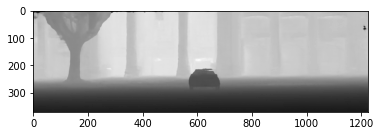

In [38]:
import numpy as np
from matplotlib import pyplot as plt

img_array = np.load('pseudo_lidar_V2/results/sdn_kitti_train_set/depth_maps/test/007481.npy')

plt.imshow(img_array, cmap='gray')
plt.show()

In [39]:
!cd pseudo_lidar_V2/ && python ./src/preprocess/generate_lidar_from_depth.py --calib_dir ./kitti/testing/calib/ --depth_dir ./results/sdn_kitti_train_set/depth_maps/test/ --save_dir ./results/sdn_kitti_train_set/pseudo_lidar_trainval/

Finish Depth 007481


Data will be available as bin file. Next step converts to .ply file 

In [18]:
from pathlib import Path
import numpy as np
import os.path
import math

def loadKittiVelodyneFile(file_path, include_luminance = False):
    '''
    Loads a kitti velodyne file (ex: 000000.bin) into a list of tuples, where each tuple has (x, y, z) or (x, y, z, l)
    Right now it discards the 4th vaule of each point, i.e. the luminance
    Argument:
        - include_luminance: if the function should also store the pont intensisty value in the list of points
    '''
    # Source: https://github.com/hunse/kitti/blob/master/kitti/velodyne.py
    points = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    points = points[:, :3]  # exclude luminance

    point_tuple_list = []
    for i in range(len(points)):
        point_tuple_list.append((points[i][0], points[i][1], points[i][2],))

    return point_tuple_list

def savePlyFile(filepath, tuple_list, attributes = None, color_for_every_point = (0, 255, 0)):
    '''
    For testing in the Main.py file
    Save list of points (possibly with attributes such as color) into a .PLY formated file
    Arguments: 
        - tuple_list: list of points and their attributes
        - attributes: to indicate what type of attributes are included in the points:
            - c: each point has position + color (r, g, b)
    '''
    with open(filepath, "w") as the_file:
        header_lines = ["ply", "format ascii 1.0"]
        header_lines.append("element vertex " + str(len(tuple_list)))
        header_lines.append("property float x")
        header_lines.append("property float y")
        header_lines.append("property float z")

        # if point have color 
        if attributes == "c":
            header_lines.append("property uchar red")
            header_lines.append("property uchar green")
            header_lines.append("property uchar blue")
        
        header_lines.append("end_header")
        
        for i in range(0, len(header_lines)):
            the_file.write(header_lines[i] + "\n")

        for i in range(0, len(tuple_list)):
            if attributes == "c" and len(tuple_list[i]) <= 3:    # if the points dont have color, but the attributes is set to "c"
                new_tuple = (tuple_list[i][0], tuple_list[i][1], tuple_list[i][2], color_for_every_point[0], color_for_every_point[1], color_for_every_point[2])
                the_file.write(tupleToStr(new_tuple) + "\n")
            else:
                the_file.write(tupleToStr(tuple_list[i]) + "\n")

def tupleToStr(tuple):
    '''
    Converts a tuple of N size into a string, where each element is separated by a space.
    Arguments:
    - tuple: tuple to be converted into string
    Returns:
        - string with the tuple values
    '''
    tuple_string = ""
    for i in range(0, len(tuple)):
        if i == (len(tuple)-1):
            tuple_string += str(tuple[i])
        else:
            tuple_string += str(tuple[i]) + " "
 
    return tuple_string

In [40]:
ptl = loadKittiVelodyneFile('/content/pseudo_lidar_V2/results/sdn_kitti_train_set/pseudo_lidar_trainval/007481.bin')
savePlyFile('/content/007481.ply', ptl)